# Korean Hate Speech Classifier
## Written by: [Jehwan Kim](github.com/kreimben)
## Date: 19th Feb 2024
## Referenced Paper: 
* [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

### Load the word2vec model first,

In [2]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn

import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

%matplotlib inline

### And then, load labeled data using pandas

In [3]:
dev_df = pd.read_csv('./labeled/dev.tsv', sep='\t')
train_df = pd.read_csv('./labeled/train.tsv', sep='\t')

In [4]:
train_df.head()

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate


In [5]:
dev_df.head()

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive


### In `hate` column, `offensive`, `none`, `hate`.
### In `contain_gender_bias` column, `True`, `False`.
### In `bias` column, `none`, `gender`, `others`.

In [6]:
# combine train and dev data.
df = pd.concat([dev_df, train_df], ignore_index=True)
df.sample(5)

,comments,contain_gender_bias,bias,hate
3726,사람에겐 싫어할 권리도 있다 왜 모든이가 널 이해해줘야 하는거냐? LGBT를 싫어할...,True,gender,hate
4800,약태환. . 이미 내 머리속에선 지워졌다.,False,none,offensive
6683,자연미인도 아닌게... 네이버일마들 자꾸 띄우는겨? 지겹네 아오~~,False,none,hate
1781,"꼴랑 이백 ,삼백?너무 한거 아녀?이억,삼억 해도 모자랄판인데!",False,none,none
2133,너무 안타깝네요....삼가 고인의 명복을 빕니다하늘나라에서 부모님과 아이를 잘 지켜...,False,none,none


In [7]:
df.hate.value_counts(), dev_df.contain_gender_bias.value_counts(), dev_df.bias.value_counts()

(hate
 none         3646
 offensive    2688
 hate         2033
 Name: count, dtype: int64,
 contain_gender_bias
 False    404
 True      67
 Name: count, dtype: int64,
 bias
 none      342
 gender     67
 others     62
 Name: count, dtype: int64)

### Load words data and tokeniser from past project.

In [8]:
import pickle

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('words.pkl', 'rb') as handle:
    words = pickle.load(handle)

In [9]:
from utils.stopwords import STOP_WORDS


def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    preprocess = lambda x: [w for w in x if w not in STOP_WORDS]
    return preprocess(tokens)

In [10]:
sample = df.sample(1).comments.values[0]

sample, tokenize(sample)

('개oooo새oooo끼가 19살? 장난하는것도아니구. 먹는 음식 가지고 장난좀 하지 말자.',
 ['개oooo새oooo',
  '끼가',
  '19살',
  '?',
  '장난하는것',
  '구.',
  '먹는',
  '음식',
  '가지고',
  '장난',
  '말자.'])

In [11]:
df['tokens'] = df['comments'].apply(tokenize)
# 공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])
df.head()

C:\Users\aksid\AppData\Local\Temp\ipykernel_14504\1445675357.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
C:\Users\aksid\AppData\Local\Temp\ipykernel_14504\1445675357.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])


,comments,contain_gender_bias,bias,hate,tokens
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,0,none,0,"[송중기, 시대, 극은, 믿고, 본다., 첫회, 신선, 았다, .]"
1,지현우 나쁜놈,0,none,1,"[지현우, 나쁜놈]"
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,0,none,1,"[알바, 쓰고, 많이, 만들면, 되지, 돈, 욕심, 으면, 골목, 식당, 왜나온겨,..."
3,설마 ㅈ 현정 작가 아니지??,1,gender,1,"[ㅈ, 현정, 작가, ??]"
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,0,none,1,"[이미자, 송혜교, 돈이, 그리, 으면, 탈세, 말고, 그돈, 평소, 불우이웃, 기..."


In [12]:
vocab = set()
for sentence in df.tokens:
    for word in sentence: vocab.add(word)

# TODO: filter the stopwords
vocab_size = len(vocab)

### Vectorise

In [13]:
with open('vectorizer.pkl', 'rb') as handle:
    vectorizer = pickle.load(handle)

### Encoding

In [14]:
df['encoding'] = df['comments'].apply(vectorizer.encode_a_doc_to_list)
df.encoding

0         [13834, 366, 55661, 671, 1342, 16079, 423, 432]
1                                                  [6021]
2       [750, 384, 2886, 332, 1898, 10604, 3279, 21690...
3                               [1990, 1092, 75890, 9257]
4       [84631, 533, 15596, 533, 454, 171, 779, 5641, ...
                              ...                        
8362                                        [2805, 11384]
8363                       [2805, 7442, 3105, 3781, 3744]
8364              [46019, 1577, 58, 591, 1505, 22957, 58]
8365    [4232, 882, 75943, 769, 4678, 887, 22943, 4270...
8366       [396, 1469, 1727, 36544, 1694, 30, 3644, 5144]
Name: encoding, Length: 8367, dtype: object

In [15]:
X_data = df['encoding']
y_data = df['hate']
print(y_data.value_counts())
len(X_data), len(y_data), len(X_data) == len(y_data)

hate
1    4721
0    3646
Name: count, dtype: int64


(8367, 8367, True)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.1, random_state=0, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=0, stratify=y_train)

y_train.value_counts()

hate
1    3824
0    2953
Name: count, dtype: int64

In [17]:
print('공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.')
print('--------훈련 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_train.value_counts()[1] / len(y_train) * 100, 3)}%')
print(f'일반 댓글 = {round(y_train.value_counts()[0] / len(y_train) * 100, 3)}%')
print('--------검증 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_valid.value_counts()[1] / len(y_valid) * 100, 3)}%')
print(f'일반 댓글 = {round(y_valid.value_counts()[0] / len(y_valid) * 100, 3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_test.value_counts()[1] / len(y_test) * 100, 3)}%')
print(f'일반 댓글 = {round(y_test.value_counts()[0] / len(y_test) * 100, 3)}%')

공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
--------훈련 데이터의 비율-----------
혐오 댓글 = 56.426%
일반 댓글 = 43.574%
--------검증 데이터의 비율-----------
혐오 댓글 = 56.441%
일반 댓글 = 43.559%
--------테스트 데이터의 비율-----------
혐오 댓글 = 56.392%
일반 댓글 = 43.608%


### Padding

댓글의 최대 길이 : 39
댓글의 평균 길이 : 9.449018739855394


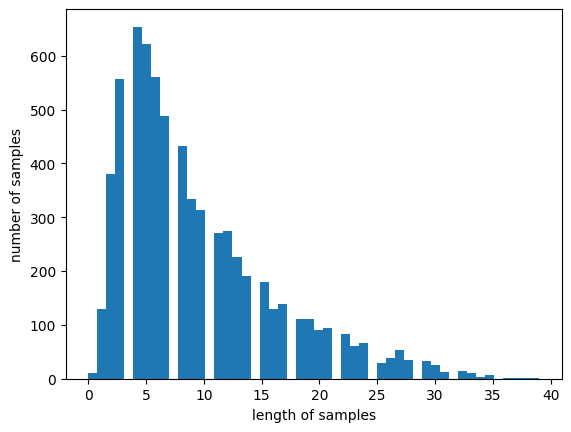

In [18]:
print('댓글의 최대 길이 :', max(len(review) for review in X_train))
print('댓글의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
max_len = max(len(review) for review in X_train)

### 길이가 길지 않아서 그냥 최대값 그대로 진행합니다. (패딩)

In [20]:
def pad_sequences(sentences: [[int]], max_len: int) -> np.ndarray:
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [21]:
padded_X_train = pad_sequences(X_train, max_len=max_len)
padded_X_valid = pad_sequences(X_valid, max_len=max_len)
padded_X_test = pad_sequences(X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (6777, 39)
검증 데이터의 크기 : (753, 39)
테스트 데이터의 크기 : (837, 39)


In [22]:
padded_X_test[:5, :]

array([[   134,   1488,   1208,  45102,  43648,   1988,  18220,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [  1224,      0,     33,    663,    122,   2622,   2151,  42010,
          3199,  25792,   1369,   9438,  26509,   9196,  37384,  11499,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [ 71953,   2929,   5341,   8097,    614,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
      

### Modeling

In [23]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([1, 1, 0, 1, 1])


In [36]:
from torchmetrics.functional import accuracy


class TextCNNLightning(L.LightningModule):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, train_batch_size):
        super().__init__()
        self.lr = None
        self.train_batch_size = train_batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)  # embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Log loss
        self.log("train_loss", loss)

        # Return loss
        return loss

    def __accuracy(self, outputs, labels):
        predictions = outputs.argmax(dim=1)  # Get indices of highest probability
        correct = (predictions == labels).sum().item()
        acc = correct / len(labels)
        return acc

    def validation_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = self.__accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def test_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = self.__accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("test_loss", loss)
        self.log("test_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def train_dataloader(self):
        encoded_train = torch.tensor(padded_X_train).to(torch.int32)
        train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=7,
                                                       persistent_workers=True, batch_size=self.train_batch_size)
        return train_dataloader

    def val_dataloader(self):
        encoded_valid = torch.tensor(padded_X_valid).to(torch.int32)
        valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
        valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=7,
                                                       persistent_workers=True)
        return valid_dataloader

    def test_dataloader(self):
        encoded_test = torch.tensor(padded_X_test).to(torch.int32)
        test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=7)
        return test_dataloader

In [37]:
# HPO using optuna

def objective(trial):
    # Define the hyperparameter space
    embedding_dim = trial.suggest_int("embedding_dim", 100, 500)
    n_filters = trial.suggest_int("n_filters", 100, 300)
    dropout_rate = trial.suggest_float('dropout_rate', .1, .9)

    # Suggest a logarithmic value
    log_base_2_value = trial.suggest_int('log_base_2_value', 0, 10)
    # Convert to actual value
    train_batch_size = 2 ** log_base_2_value

    # Initialize the model with the hyperparameters
    model = TextCNNLightning(vocab_size=vocab_size, embedding_dim=embedding_dim, n_filters=n_filters,
                             filter_sizes=[3, 4, 5], output_dim=2, dropout=dropout_rate,
                             train_batch_size=train_batch_size)

    # Trainer settings
    trainer = L.Trainer(
        accelerator="cpu", max_epochs=15
    )

    # Train the model
    trainer.fit(model)

    # Evaluate the model performance
    return trainer.callback_metrics["train_loss"]


In [38]:
import optuna

# Create a study object
study = optuna.create_study()  # or 'maximize' based on your goal
study.optimize(objective, n_trials=100)  # Specify the number of trials

# Print the best hyperparameters
print(f"Best trial: {study.best_trial.params}")


[I 2024-02-20 09:59:39,218] A new study created in memory with name: no-name-9007baf9-4c7d-43ea-8480-65dc51550d54
GPU available: False, used: False
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 2.7 M 
1 | convs     | ModuleList | 259 K 
2 | fc        | Linear     | 1.2 K 
3 | dropout   | Dropout    | 0     
-----------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.788    Total estimated model params size (MB)

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 2.7 M 
1 | convs     | ModuleList | 259 K 
2 | fc        | Linear     | 1.2 K 
3 | dropou

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\aksid\PycharmProjects\KoreanHateSpeechClassifier\venv\lib\site-packages\torch\utils\data\dataloader.py:558: UserWarning: This DataLoader will create 7 worker processes in total. Our suggested max number of worker in current system is 6 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[W 2024-02-20 09:59:42,804] Trial 0 failed with parameters: {'embedding_dim': 110, 'n_filters': 196, 'dropout_rate': 0.41145273798127213, 'log_base_2_value': 8} because of the following error: IndexError('index out of range in self').
Traceback (most recent call last):
  File "C:\Users\aksid\PycharmProjects\KoreanHateSpeechClassifier\venv\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  

IndexError: index out of range in self

In [ ]:
# # model = TextCNNLightning(vocab_size=vocab_size, num_labels=len(set(y_train)), l=l)
# model = TextCNNLightning(vocab_size=vocab_size, embedding_dim=300, n_filters=100,
#                          filter_sizes=[3, 4, 5], output_dim=2, dropout=.5, train_batch_size=512)
# model.to(device)
# 
# vocab_size, len(set(y_train))

### Train

In [ ]:
# %%time
# 
# from lightning.pytorch.callbacks import LearningRateFinder
# 
# trainer = L.Trainer(
#     accelerator="auto", devices="auto", strategy="auto",
#     max_epochs=30, callbacks=[LearningRateFinder()]
# )
# trainer.fit(model=model)

In [ ]:
# trainer.test()